# Examining Home Configurations and Their Effect on Sale Prices
### by Steven Tran

## 01: EDA and Cleaning

|Project Notebooks|
|--------|
|[00_Problem_Statement_and_Project_Overview](00_Problem_Statement_and_Project_Overview.ipynb)|
|[01_EDA_and_Cleaning](01_EDA_and_Cleaning.ipynb)|
|[02_Preprocessing_FeatureEngineering_Modeling](02_Preprocessing_FeatureEngineering_Modeling.ipynb)|
|[03_Kaggle_Submissions](04_Kaggle_Submissions.ipynb)|

### Import required packages.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

### Load in the data.

In [2]:
#read it in:
ames_eda = pd.read_csv('../datasets/train.csv')

#show first few lines:
ames_eda.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
#adjust the column names so they are all lowercase and have whitespace stripped:
ames_eda.columns = [x.lower().replace(' ','_') for x in ames_eda.columns]

In [4]:
#get basic info
ames_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

---

#### First order of investigation is to take a closer look at any variables which have nulls in them. Identify the relevant columns below:

In [5]:
#use a dict comprehension to grab columns where there are null values.
null_cols = {column: [null_sum] for column, null_sum in list(zip(ames_eda.columns,ames_eda.isnull().sum())) if null_sum > 0}

There are a lot of features with null values, but null values don't necessarily mean the data are missing, according to the [Data Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) for this dataset (from this point on referred to as *'the Dictionary'*). Perhaps it makes the most sense just to proceed down the list and determine how we'll treat each column's nulls on a case-by-case basis.

In [6]:
#just running this to get a sense for where our nulls occur:
pd.DataFrame.from_dict(null_cols,'index',columns=['count of null obvs']).sort_values('count of null obvs', ascending = False)

,count of null obvs
pool_qc,2042
misc_feature,1986
alley,1911
fence,1651
fireplace_qu,1000
lot_frontage,330
garage_yr_blt,114
garage_cond,114
garage_qual,114
garage_finish,114


---
#### `pool_qc`, or pool quality
The features with the most nulls is `pool_qc`. According to the Dictionary, the variable is defined as follows:
>Pool QC (Ordinal): Pool quality
>		
>       Ex	Excellent
>       Gd	Good
>       TA	Average/Typical
>       Fa	Fair
>       NA	No Pool

So it's not that there are 2042 homes with missing pool quality ratings, there are 2042 homes **without pools**! I want to make sure we can factor pool quality into the model, but obviously only for those homes which have pools to begin with. We'll split the column into two binary fields -- one indicating whether the home has a pool and one indicating the pool quality.

Something vexxing if you look back at the `ames_eda.info()` is that the other pool-related field, `pool_area` does not have as many nulls... this calls for inspection. We find from the Dictionary that `pool_area` measures the area of the pool (if there is one) in square feet. Reviewing the `pool_area.value_counts()` gives results we'd expect -- where the home didn't have a pool, it had 0 (not missing) sqft of pool area.

In [7]:
ames_eda.pool_area.value_counts()

0      2042
228       1
368       1
480       1
576       1
648       1
738       1
800       1
519       1
561       1
Name: pool_area, dtype: int64

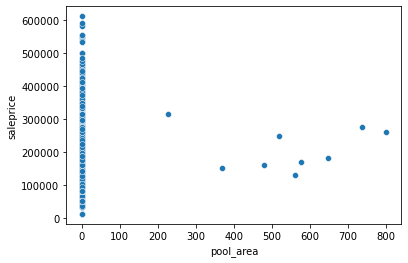

In [8]:
#check if there's a linera relationship between saleprice and pool_area
sns.scatterplot(x=ames_eda.pool_area,y=ames_eda.saleprice);

The scatterplot between `pool_area` and `sale_price` is not linear and so I don't have any issues dropping this column. If we use the treatment described above on `pool_qc`, we'll have pool quality data for those few properties that do have a pool, but we can't use both `pool_qc` and `pool_area` and not have issues with the meeting the no multicollinearity assumption.

So that said, I will decide to **drop** `pool_area` for now, and fill the NAs in `pool_qc` with 'None'.

In [9]:
ames_eda.drop(columns='pool_area',inplace = True)
ames_eda['pool_qc'] = ames_eda['pool_qc'].fillna('None')

---

#### `misc_feature`

Next up is `misc_feature`, with 1986 null values. Like with pool quality above, the Dictionary is helpful for providing context:

>Misc Feature (Nominal): Miscellaneous feature not covered in other categories
>		
>       Elev	Elevator
>       Gar2	2nd Garage (if not described in garage section)
>       Othr	Other
>       Shed	Shed (over 100 SF)
>       TenC	Tennis Court
>       NA	  None


We can rest assured that the 1986 null `misc_feature` values are just the **absence** of a miscellaneous feature not described elsewhere in the dataset. Only 65 of the homes in the dataset have a non-null value here.

We'll keep this column, and in pre-processing we'll dummify the categories to observe any effects. We can always remove this later if it proves problematic.

The missing values in this column mean an absence of a miscellaneous feature, so for `misc_feature`, I will fill the NAs with 'None'

In [10]:
ames_eda['misc_feature'] = ames_eda['misc_feature'].fillna('None')
ames_eda.misc_feature.value_counts()
#Now there are as many values as there are observations!

None    1986
Shed      56
Gar2       4
Othr       3
TenC       1
Elev       1
Name: misc_feature, dtype: int64

---

#### `alley`

Again (noticing a pattern here), the Dictionary tells us NA means there is simply no alley access.

>Alley (Nominal): Type of alley access to property
>
>       Grvl	Gravel
>       Pave	Paved
>       NA 	 No alley access

We'll apply the same treatment as `misc_feature`. Fill NAs with 'None', then later we'll dummify the feature.

In [11]:
ames_eda['alley'] = ames_eda['alley'].fillna('None')
ames_eda.alley.value_counts()

None    1911
Grvl      85
Pave      55
Name: alley, dtype: int64

As there are over 20 features left to go, I'm going to write a function that accepts a dataframe column and fills its NAs with 'None' if we are going to apply the same treatment as we did to `misc_feature` and `alley`. This may prove useful if we need to apply similar treatments to the fields in the testing dataset.

In [12]:
def fill_na_none(df,column):
    df[column] = df[column].fillna('None')
    print(df[column].value_counts())
    return f'Fill-NA on [{column}] complete.'

In [13]:
#just some test output:
fill_na_none(ames_eda,'alley')

None    1911
Grvl      85
Pave      55
Name: alley, dtype: int64


'Fill-NA on [alley] complete.'

---

#### `fence`

The `fence` field both indicates the presence of fencing on the property as well as the... *fence quality*? The Dictionary is both enlightening and bewildering here:

>Fence (Ordinal): Fence quality
>		
>       GdPrv	Good Privacy
>       MnPrv	Minimum Privacy
>       GdWo	 Good Wood
>       MnWw	 Minimum Wood/Wire
>       NA 	  No Fence

There's a lot to unpack in this variable's categories...
* A property may not have a fence
* But if it has a fence, it may have one with either good privacy or minimum privacy (but also implicitly, not-good wood, or worse... a fence made with minimal wood or perhaps wire?)
* But ALSO, the fence will either be made of good wood OR be made with minimal wood or wire, AND have ambiguous privacy?

Though it's hard to gauge how the fence's ability to provide privacy and whether its material is wood would be objectively better, we will apply the same treatment as some of the previous variables and fill the NAs in this column with 'None' to indicate the absence of a fence.

If during model tuning we find that there are simply too many features being included, this will be among the first to go.

In [14]:
#use our function defined in the last cell:
fill_na_none(ames_eda,'fence')

None     1651
MnPrv     227
GdPrv      83
GdWo       80
MnWw       10
Name: fence, dtype: int64


'Fill-NA on [fence] complete.'

---

#### `fireplace_qu`

Next up with 1000 (about half the observations) null values is `fireplace_qu`. From the Dictionary:

>FireplaceQu (Ordinal): Fireplace quality
>
>       Ex	Excellent - Exceptional Masonry Fireplace
>       Gd	Good - Masonry Fireplace in main level
>       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
>       Fa	Fair - Prefabricated Fireplace in basement
>       Po	Poor - Ben Franklin Stove
>       NA	No Fireplace


We'll apply the same treatment as the last few variables, filling NAs here with 'None'.

In [15]:
fill_na_none(ames_eda,'fireplace_qu')

None    1000
Gd       523
TA       407
Fa        59
Ex        31
Po        31
Name: fireplace_qu, dtype: int64


'Fill-NA on [fireplace_qu] complete.'

---

#### `lot_frontage`

Next up with 330 nulls is `lot_frontage`. From the Dictionary:

>Lot Frontage (Continuous): Linear feet of street connected to property

And that's it. The dataset's author notes this is a continuous variable, and as such there aren't any categories here. Therefore, the value of 0 means 0 feet of street are connected to the property, and null values are truly missing data points.

330 observations out of our ~2000 observation dataset would be a lot to drop. I want to move on, but will come back to this after more of the cleaning is done.

As I don't know what strategy to take to impute reasonable guesses for `lot_frontage` where it is missing, I aim to later develop a sub-model predicing `lot_frontage`, and use it to fill in these missing values for the main project model.

<AxesSubplot:xlabel='lot_frontage', ylabel='saleprice'>

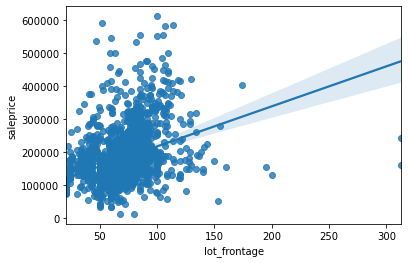

In [16]:
sns.regplot(x=ames_eda.lot_frontage,y=ames_eda.saleprice)

<AxesSubplot:xlabel='lot_frontage', ylabel='Count'>

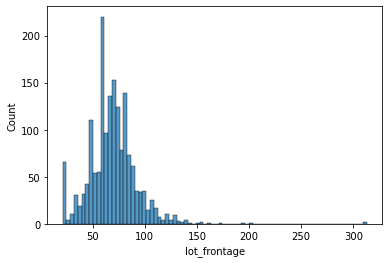

In [17]:
sns.histplot(ames_eda['lot_frontage'])

---

#### `garage...`

Grouping the discussion for the 7 features below since they all are related to garages.

>**feature          nulls**  
>garage_yr_blt 	114  
>garage_cond 	114  
>garage_qual 	114  
>garage_finish 	114  
>garage_type 	113   
>garage_cars 	1  
>garage_area 	1  

From the Dictionary:

>Garage Yr Blt (Discrete): Year garage was built
>Garage Cond (Ordinal): Garage condition
>
>       Ex	Excellent
>       Gd	Good
>       TA	Typical/Average
>       Fa	Fair
>       Po	Poor
>       NA	No Garage  

>Garage Cond (Ordinal): Garage condition
>
>       Ex	Excellent
>       Gd	Good
>       TA	Typical/Average
>       Fa	Fair
>       Po	Poor
>       NA	No Garage

>Garage Qual (Ordinal): Garage quality
>
>       Ex	Excellent
>       Gd	Good
>       TA	Typical/Average
>       Fa	Fair
>       Po	Poor
>       NA	No Garage  

>Garage Finish (Ordinal)	: Interior finish of the garage
>
>       Fin	Finished
>       RFn	Rough Finished	
>       Unf	Unfinished
>       NA	 No Garage  

>Garage Type (Nominal): Garage location
>		
>       2Types	More than one type of garage
>       Attchd	Attached to home
>       Basment	Basement Garage
>       BuiltIn	Built-In (Garage part of house - typically has room above garage)
>       CarPort	Car Port
>       Detchd	Detached from home
>       NA	  No Garage

>Garage Cars (Discrete): Size of garage in car capacity

>Garage Area (Continuous): Size of garage in square feet


Of particular note, there are only 113 nulls in `garage_type`, where there are 114 nulls in each of the other garage-related categories.


In [18]:
#grab the df indices for each of the observations with missing garage_type.
index_of_113 = ames_eda[ames_eda['garage_type'].isnull()]['garage_type'].index

In [19]:
#This list comprehension shows which index position has nulls for all the garage features except garage type:
[x for x in list(ames_eda[ames_eda['garage_yr_blt'].isnull()].index) if x not in list(index_of_113)]

[1712]

In [20]:
#Take a look at the row:
ames_eda.loc[1712][['garage_type','garage_yr_blt','garage_cond','garage_qual','garage_finish', 'garage_cars', 'garage_area']]

garage_type      Detchd
garage_yr_blt       NaN
garage_cond         NaN
garage_qual         NaN
garage_finish       NaN
garage_cars         NaN
garage_area         NaN
Name: 1712, dtype: object

From above, we see that our one row with non-missing `garage_type` has a Detached garage, but missing information on the other garage variables. 

In [21]:
ames_eda['garage_type'].value_counts(normalize=True)

Attchd     0.625903
Detchd     0.276574
BuiltIn    0.068111
Basment    0.013932
2Types     0.009804
CarPort    0.005676
Name: garage_type, dtype: float64

Since Detached garages make up over a quarter of the `garage_types`, I think it would be okay to fill this row's NAs, as well as the `garage_type`, with 'None'. It doesn't make much sense to me to retain this row's non-missing `type`, but have 'None' indicating the absence of a garage in fields where there is no information.

But first, I want to make sure we are only cleaning columns we intend to keep. Notice there's a field for number of cars the garage has capacity for (discrete) and area in square feet for the garage (continuous). As the former is determined by the latter, these would be collinear variables and so inclusion of both does not make sense. Review the scatterplot:

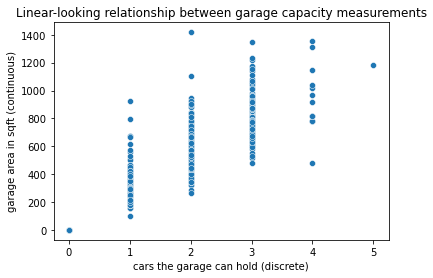

In [22]:
sns.scatterplot(x=ames_eda.garage_cars,y=ames_eda.garage_area)
plt.title('Linear-looking relationship between garage capacity measurements')
plt.xlabel('cars the garage can hold (discrete)')
plt.ylabel('garage area in sqft (continuous)');

Yep, the case for dropping garage car capacity makes sense to me.

In [23]:
ames_eda.drop(columns=['garage_cars'], inplace=True)

On another garage-related matter, we're left with just `garage_area` and `garage_yr_blt` as numeric fields. We don't want to leave the year a garage is built in as a numeric field for coefficient estimation because the result would be unintelligble, especially since we don't have a good value to impute for properties which don't have a garage.

Hence, we'll cast the `garage_yr_blt` field as an object to later dummify for those properties which do have a garage:

In [24]:
#The fillna step casts the field as an obj:
ames_eda['garage_yr_blt'] = ames_eda['garage_yr_blt'].fillna('None')
#this is just to make sure all the floats are strings and strips their decimals:
ames_eda['garage_yr_blt'] = ames_eda['garage_yr_blt'].apply(lambda x: str(x).replace('.0','') if x != 'None' else x)

With all those matters wrapped up, we can finally address the one row with non-missing `garage_type`, and then address the other `garage_x` fields:

In [25]:
#change 'Detachd' to 'none':
ames_eda.loc[1712,'garage_type'] = 'None'

#fill the discrete/categorical 'garage_x' columns with None where null:
for column in ['garage_type','garage_cond','garage_qual','garage_finish']:
    fill_na_none(ames_eda,column)

#fill the nulls in the 'garage_area' column with 0.0:
ames_eda['garage_area'] = ames_eda['garage_area'].fillna(0.0)

Attchd     1213
Detchd      535
BuiltIn     132
None        114
Basment      27
2Types       19
CarPort      11
Name: garage_type, dtype: int64
TA      1868
None     114
Fa        47
Gd        12
Po         8
Ex         2
Name: garage_cond, dtype: int64
TA      1832
None     114
Fa        82
Gd        18
Ex         3
Po         2
Name: garage_qual, dtype: int64
Unf     849
RFn     579
Fin     509
None    114
Name: garage_finish, dtype: int64


---

#### `bsmt...`

From garages to basements! These columns with nulls have much fewer missing values than the others, but we'll discuss all the basement-related fields collectively, and will probably apply similar treatments as we did for garages above.

>**Feature nulls**  
bsmt_exposure 	58  
bsmtfin_type_2 	56  
bsmt_cond 	55  
bsmt_qual 	55  
bsmtfin_type_1 	55  
bsmt_half_bath 	2  
bsmt_full_bath 	2  
total_bsmt_sf 	1  
bsmt_unf_sf 	1  
bsmtfin_sf_2 	1  
bsmtfin_sf_1 	1  

Notes from the Dictionary:

>Bsmt Qual (Ordinal): Evaluates the height of the basement
>
>       Ex	Excellent (100+ inches)	
>       Gd	Good (90-99 inches)
>       TA	Typical (80-89 inches)
>       Fa	Fair (70-79 inches)
>       Po	Poor (<70 inches
>       NA	No Basement
		
>Bsmt Cond (Ordinal): Evaluates the general condition of the basement
>
>       Ex	Excellent
>       Gd	Good
>       TA	Typical - slight dampness allowed
>       Fa	Fair - dampness or some cracking or settling
>       Po	Poor - Severe cracking, settling, or wetness
>       NA	No Basement
	
>Bsmt Exposure	(Ordinal): Refers to walkout or garden level walls
>
>       Gd	Good Exposure
>       Av	Average Exposure (split levels or foyers typically score average or above)	
>       Mn	Mimimum Exposure
>       No	No Exposure
>       NA	No Basement
	
>BsmtFin Type 1	(Ordinal): Rating of basement finished area
>
>       GLQ	Good Living Quarters
>       ALQ	Average Living Quarters
>       BLQ	Below Average Living Quarters	
>       Rec	Average Rec Room
>       LwQ	Low Quality
>       Unf	Unfinshed
>       NA	 No Basement

>BsmtFinType 2	(Ordinal): Rating of basement finished area (if multiple types)
>
>       GLQ	Good Living Quarters
>       ALQ	Average Living Quarters
>       BLQ	Below Average Living Quarters	
>       Rec	Average Rec Room
>       LwQ	Low Quality
>       Unf	Unfinshed
>       NA	 No Basement

>BsmtFin SF 1 (Continuous): Type 1 finished square feet

>BsmtFin SF 2 (Continuous): Type 2 finished square feet

>Bsmt Unf SF (Continuous): Unfinished square feet of basement area

>Total Bsmt SF (Continuous): Total square feet of basement area

>Bsmt Full Bath (Discrete): Basement full bathrooms

>Bsmt Half Bath (Discrete): Basement half bathrooms

For the categorical variables, missingness looks to mean absence of a basement.

Looking at the definitions for the continuous `bsmt` variables, I think we'll have a similar problem as the `garage` capacity fields: there's probably collinearity here. If so, we'll want to pare down the number of fields to keep. Inspect for linearity below:



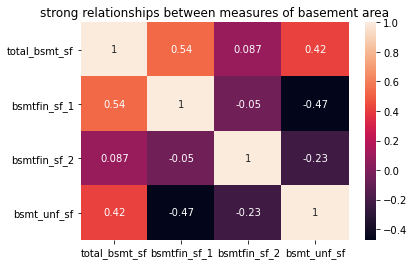

In [26]:
#check linearity between TotalbsmtSF and the others:

bsmt_sf_cols = ['total_bsmt_sf','bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf']
corr = ames_eda[bsmt_sf_cols].corr()
sns.heatmap(corr, annot=True)
plt.title('strong relationships between measures of basement area');

<Figure size 288x288 with 0 Axes>

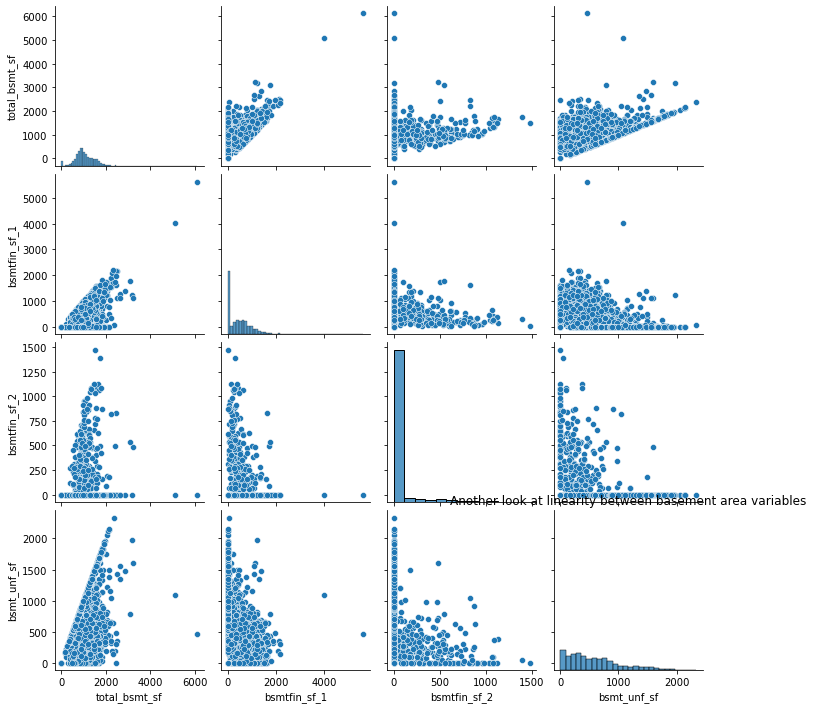

In [27]:
plt.figure(figsize=(4,4))
sns.pairplot(ames_eda[bsmt_sf_cols])
plt.title('Another look at linearity between basement area variables');

Based on the two plots above, which illustrate the linearity between variables, I think it's fair to drop all the `bsmt` capacity measures save for `total_bsmt_sf`.

In [28]:
ames_eda.drop(columns=['bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf'],inplace=True)

To deal with the remaining `bsmt` fields, I am going to apply a rough rule that if the `bsmt_qual` (which is actually a measure of the basement's height as a quality rating) is NA, that the home doesn't have a basement. For homes which meet this rule, do the following:

* For the categorical `bsmt` variables, `.fillna()` with 'None' as we've done with the other columns.
* For the numeric `bsmt` variables, fill the NAs with 0.

However, there's three rows with missing values in `bsmt_exposure` which don't have a missing `bsmt_qual` value:

In [29]:
#grab the basement cols:
bsmt_cols = [column for column in ames_eda.columns if 'bsmt' in column]

In [30]:
#homes with nulls in exposure which are NOT in the homes with nulls in bsmt_qual:
weird_exposures = ames_eda[(ames_eda['bsmt_exposure'].isnull()) & ~(ames_eda.index.isin(ames_eda[ames_eda['bsmt_qual'].isnull()].index))][bsmt_cols]
weird_exposures

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
1456,Gd,TA,NaN,Unf,Unf,725.0,0.0,0.0
1547,Gd,TA,NaN,Unf,Unf,1595.0,0.0,0.0
1997,Gd,TA,NaN,Unf,Unf,936.0,0.0,0.0


The missing exposure values might lead us to believe there isn't a basement, but that would contradict the other information we're seeing from the other fields.

Per the Dictionary, 'NA' would mean no basement exposure, but 'No' would mean no exposure. for each of these three rows, change `bsmt_exposure` to 'No':

In [31]:
ames_eda.loc[weird_exposures.index,'bsmt_exposure'] = 'No' 

There's also one row where `bsmtfin_type_2` is missing despite having a non-missing `bsmt_qual` row. The row index is 1147. There's no category this field can take which indicates there's no second basement type to rate, so we'll change the value to unfinished:

In [32]:
ames_eda.loc[1147,'bsmtfin_type_2'] = 'Unf'

Now we can finally apply that rough rule I mentioned a couple cells ago. As a reminder:

* For the categorical `bsmt` variables, `.fillna()` with 'None' as we've done with the other columns.
* For the numeric `bsmt` variables, fill the NAs with 0.

In [33]:
for column in bsmt_cols:
    if ames_eda[column].dtype == 'object':
        ames_eda[column] = ames_eda[column].fillna('None')
    else:
        ames_eda[column] = ames_eda[column].fillna(0.0)

In [34]:
#check missingness now:
for column in bsmt_cols:
    print(column, ames_eda[column].isnull().sum())

bsmt_qual 0
bsmt_cond 0
bsmt_exposure 0
bsmtfin_type_1 0
bsmtfin_type_2 0
total_bsmt_sf 0
bsmt_full_bath 0
bsmt_half_bath 0


---

#### `mas_vnr...` 

Before we get to unfinished business, let's look at **masonry veneer type and area**.

>**Null features**  
mas_vnr_area 	22  
mas_vnr_type 	22  

From the Dictionary:

>Mas Vnr Type (Nominal): Masonry veneer type
>
>       BrkCmn	Brick Common
>       BrkFace	Brick Face
>       CBlock	Cinder Block
>       None	None
>       Stone	Stone
	
>Mas Vnr Area (Continuous): Masonry veneer area in square feet

This treatment should be fairly straightforward. If there's no value, the home doesn't have masonry veneer. Fill NAs with 'None' or 0:

In [35]:
fill_na_none(ames_eda,'mas_vnr_type')

None       1240
BrkFace     630
Stone       168
BrkCmn       13
Name: mas_vnr_type, dtype: int64


'Fill-NA on [mas_vnr_type] complete.'

In [36]:
#Doing this last one manually since area would be 0 if there's no masonry veneer:
ames_eda['mas_vnr_area'] = ames_eda['mas_vnr_area'].fillna(0.0)

---

#### Unfinished Business: `lot_frontage`

Now that the rest of our nulls have been handled, I want to finally deal with `lot_frontage`. I'll use the K-nearest neighbors imputation method to predict what the missing values might be based on the values of other predictors.

In [37]:
#import and instantiate
from sklearn.impute import KNNImputer
knn_imp = KNNImputer()

In [38]:
#fit the imputer on the numeric columns in the dataset:
knn_imp.fit_transform(ames_eda.select_dtypes(include=np.number))

array([[1.0900000e+02, 5.3335217e+08, 6.0000000e+01, ..., 3.0000000e+00,
        2.0100000e+03, 1.3050000e+05],
       [5.4400000e+02, 5.3137905e+08, 6.0000000e+01, ..., 4.0000000e+00,
        2.0090000e+03, 2.2000000e+05],
       [1.5300000e+02, 5.3530418e+08, 2.0000000e+01, ..., 1.0000000e+00,
        2.0100000e+03, 1.0900000e+05],
       ...,
       [9.1600000e+02, 9.0925301e+08, 5.0000000e+01, ..., 3.0000000e+00,
        2.0090000e+03, 1.7700000e+05],
       [6.3900000e+02, 5.3517916e+08, 2.0000000e+01, ..., 1.1000000e+01,
        2.0090000e+03, 1.4400000e+05],
       [1.0000000e+01, 5.2716213e+08, 6.0000000e+01, ..., 6.0000000e+00,
        2.0100000e+03, 1.8900000e+05]])

In [39]:
#create a dataframe with imputed values for `lot_frontage`
imputed = pd.DataFrame(knn_imp.fit_transform(ames_eda.select_dtypes(include=np.number))
                                    ,columns=ames_eda.select_dtypes(include=np.number).columns)

Above I've created a second dataframe which has imputed values for `lot_frontage`. Below, lets review the difference in distribution of `lot_frontage` for the original and imputed datasets, as well as the original vs imputed relationship with `saleprice`:

In [40]:
#compare original vs. imputed mean and variance
ames_eda.lot_frontage.mean(),  imputed.lot_frontage.mean(), ames_eda.lot_frontage.var(), imputed.lot_frontage.var()

(69.05520046484602, 69.29712335446123, 541.0579976487439, 485.3242600135564)

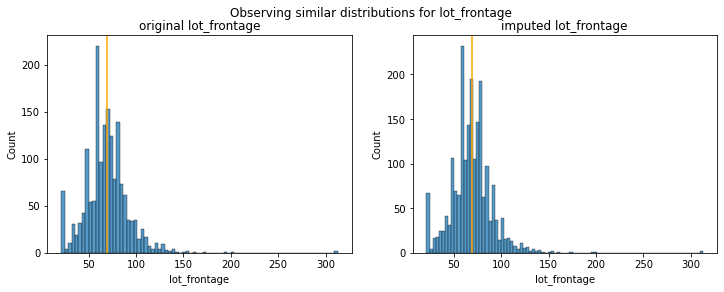

In [41]:
#code below somewhat inspired by https://www.codegrepper.com/code-examples/typescript/seaborn+two+plots+side+by+side
f, axes = plt.subplots(1,2, figsize=(12,4))
f.suptitle('Observing similar distributions for lot_frontage')
#ames_eda
sns.histplot(ames_eda.lot_frontage, ax=axes[0])
axes[0].axvline(ames_eda.lot_frontage.mean(), color='orange')
axes[0].set_title('original lot_frontage')

#imputed
sns.histplot(imputed['lot_frontage'], ax=axes[1])
axes[1].axvline(imputed.lot_frontage.mean(), color='orange')
axes[1].set_title('imputed lot_frontage');

Looks like there may be some outliers, but we'll handle those along with all the other variables' outliers in a later section. Lastly, let's review the new relationship with `saleprice` using regression plots:

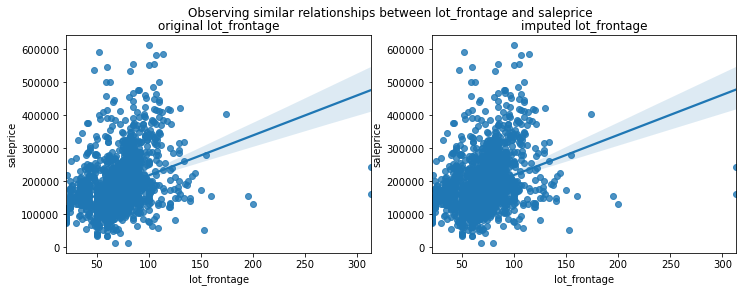

In [42]:
#code below somewhat inspired by https://www.codegrepper.com/code-examples/typescript/seaborn+two+plots+side+by+side
f, axes = plt.subplots(1,2, figsize=(12,4))
f.suptitle('Observing similar relationships between lot_frontage and saleprice')
#ames_eda
sns.regplot(x=ames_eda['lot_frontage'],y=ames_eda['saleprice'],ax=axes[0])
axes[0].set_title('original lot_frontage')

#imputed
sns.regplot(x=imputed['lot_frontage'],y=imputed['saleprice'],ax=axes[1])
axes[1].set_title('imputed lot_frontage');

On the same scales, the relationship between `lot_frontage` and `saleprice` look to be roughly identical between the original and imputed values. Those outliers mentioned earlier are very evident here, straddling the 200k saleprice mark. Let's save our work:

In [43]:
#overwrite the original lot_frontage NAs with the imputed lot frontages
ames_eda['lot_frontage'] = imputed['lot_frontage']

---

With that, we can confirm we have finally dealt with all the nulls in the dataset:

In [44]:
null_cols = {column: [null_sum] for column, null_sum in list(zip(ames_eda.columns,ames_eda.isnull().sum())) if null_sum > 0}
pd.DataFrame.from_dict(null_cols,'index',columns=['count of null obvs']).sort_values('count of null obvs', ascending = False)

,count of null obvs


Yay!

---
### Types

I want to briefly review our datatypes before proceeding to checking outliers. Check all the dtypes:

In [45]:
ames_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     2051 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            2051 non-null   object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

Some observations:
* `id`, `pid`, `ms_subclass` should probably be objects rather than ints. These fields don't measure anything on the number line and their regression coefficients in predicting `saleprice` would be unintelligible.
     * That said, I don't see how we might use `pid` at all in the model. The Dictionary defines it as the 'Parcel identification number', which won't have any business being in our model.
* `overall_qual` and `overall_cond` are rating fields on a numeric scale from 1 to 10. These should be cast as objects for the same reasons as above.
* The temporal fields, `year_built`, `year_remod/add`, `mo_sold`, and `yr_sold` should all be cast as objects for the same reasons as above.

Drop `pid` and apply the casts:

In [46]:
ames_eda.drop(columns='pid',inplace=True)
ames_eda[['id','ms_subclass','overall_qual','overall_cond','year_built','year_remod/add','mo_sold','yr_sold']] = \
    ames_eda[['id','ms_subclass','overall_qual','overall_cond','year_built','year_remod/add','mo_sold','yr_sold']].astype(str)

---

### Outliers

My strategy for identifying outlier data points will proceed roughly as follows:

* For all numeric columns, obtain correlation with `saleprice`.
* Of the most strongly correlated, check the scatterplots for any obvious outliers.
* Decide on a case-by-case basis whether to drop the observation from the dataset.

In [47]:
#first, identify the numeric columns:
ames_numerics = ames_eda.select_dtypes(include=np.number).columns

In [48]:
#get correlations with `saleprice` and assign to a variable for plotting.
corr = ames_eda[ames_numerics].corr()[['saleprice']].sort_values('saleprice',ascending=False)[1:]

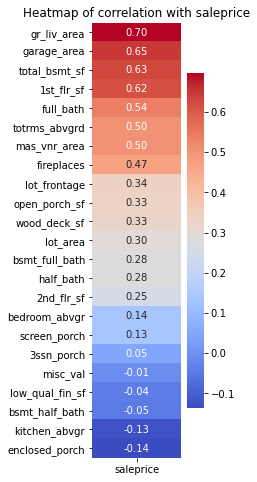

In [49]:
#plot the heatmap of the correlations on `saleprice`:
plt.figure(figsize=(2,8))
sns.heatmap(corr,annot=True,cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of correlation with saleprice');

The above will guide which columns where we really want to be judicious about identifying outliers. Since we'll be doing a few of these, let's define a function so as not to repeat ourselves too much:

In [50]:
#define a function to plot a scatter with saleprice
def scatter_w_saleprice(series):
    """Pass a dataframe series to plot in a scatter against saleprice."""
    plt.figure(figsize=(6,6))
    sns.regplot(x=series,y=ames_eda['saleprice'])
    plt.title(f'Relationship between `{series.name}` and `saleprice`')

---

#### Outliers: `gr_liv_area`

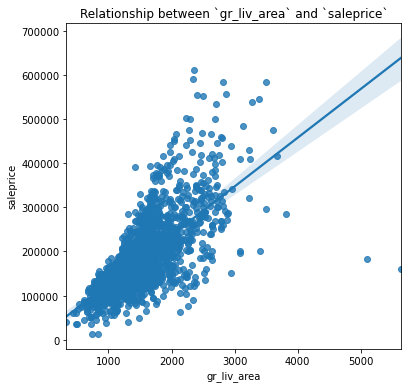

In [51]:
scatter_w_saleprice(ames_eda['gr_liv_area'])

There are two major outliers we can see above the 5,000 `gr_liv_area` mark. Let's look at those observations:

In [52]:
ames_eda[ames_eda['gr_liv_area'] > 5000][ames_numerics]

,lot_frontage,lot_area,mas_vnr_area,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,...,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,misc_val,saleprice
960,313.0,63887,796.0,6110.0,4692,950,0,5642,2.0,0.0,...,12,3,1418.0,214,292,0,0,0,0,160000
1885,128.0,39290,1224.0,5095.0,5095,0,0,5095,1.0,1.0,...,15,2,1154.0,546,484,0,0,0,17000,183850


For now, I'll add these two to a list of outliers to drop. Let's see if they show up in the plots of any of the next scatter plots.

In [53]:
outliers_to_drop = list(ames_eda[ames_eda['gr_liv_area'] > 5000][ames_numerics].index)

While we're on the subject of living area square feet, there are a couple other fields I'd theorize are at least partly described by `gr_liv_area`, which the Dictionary defines as 'Above grade (ground) living area square feet': `1st_flr_sf` and `2nd_flr_sf`. Let's check these relationships for collinearity:

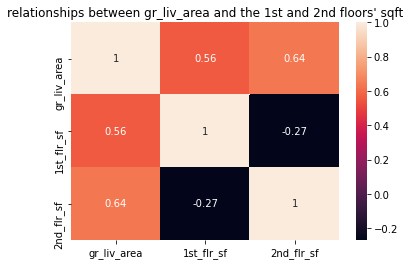

In [54]:
sns.heatmap(ames_eda[['gr_liv_area','1st_flr_sf','2nd_flr_sf']].corr(),annot=True)
plt.title('relationships between gr_liv_area and the 1st and 2nd floors\' sqft');

These look to be pretty linear relationship. So as a result, we'll drop `1st_flr_sf` and `2nd_flr_sf` from the dataset:

In [55]:
ames_eda.drop(columns=['1st_flr_sf','2nd_flr_sf'],inplace=True)

#also drop them from our numeric columns:
ames_numerics = ames_numerics.drop(['1st_flr_sf','2nd_flr_sf'])

---

#### Outliers: `garage_area`


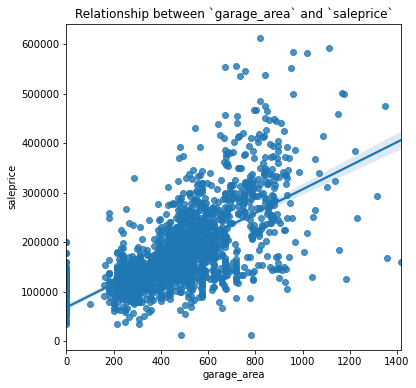

In [56]:
scatter_w_saleprice(ames_eda['garage_area'])

Not seeing anything blatantly out of bounds here... with that we'll move on. We can reassess later if need be.

---

#### Outliers: `total_bsmt_sqft`



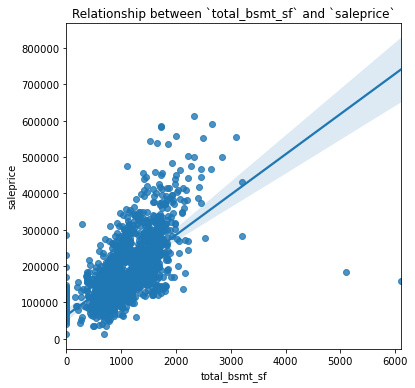

In [57]:
scatter_w_saleprice(ames_eda['total_bsmt_sf'])

There are a couple observations here with an exaggerated amount of sqft in their basement, but prices that are out of trend for the relationship characterized by the bulk of other points. Let's inspect and see if these are the homes we identified in the `gr_liv_area` review.

In [58]:
print(list(ames_eda[ames_eda['total_bsmt_sf']>5000].index), outliers_to_drop)
print('It\'s the same two properties!')

[960, 1885] [960, 1885]
It's the same two properties!


---

#### Outliers: `full_bath`

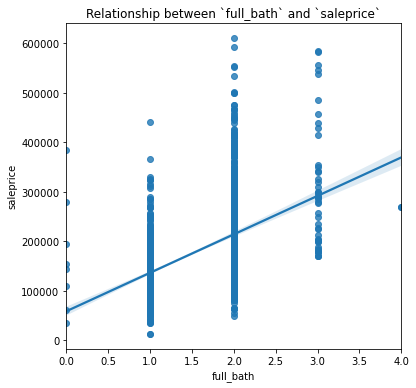

In [59]:
scatter_w_saleprice(ames_eda['full_bath'])

According to the Dictionary, `full_bath` is a discrete measure of full bathrooms above grade. I am not too concerned with what we observe in the plot above, but I am curious about the \$100k+ homes with 0.0 full bathrooms above grade. Inspect those:

In [60]:
#check bathrooms of homes with 0 full_bath, sorted descending by price:
ames_eda[ames_eda['full_bath']==0.0][[x for x in ames_numerics if 'bath' in x]+['saleprice']].sort_values('saleprice', ascending=False)

,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,saleprice
1571,2.0,0.0,0,1,385000
191,2.0,0.0,0,1,279000
1280,0.0,2.0,0,2,194201
400,2.0,0.0,0,2,153337
346,1.0,1.0,0,0,145000
744,2.0,0.0,0,2,108959
1372,1.0,0.0,0,1,61000
1518,1.0,0.0,0,0,35311


I feel okay letting this slide. The higher-priced homes without a full bathroom above ground at least have bathrooms in the basement or other half baths above ground. The only one without full bathrooms above or below ground is property 1280. The price on that house just about adheres to the linear trend we see in the chart, so I will consider this field's strangeness okay.

---

#### Outliers: `totrmsabvgrd`

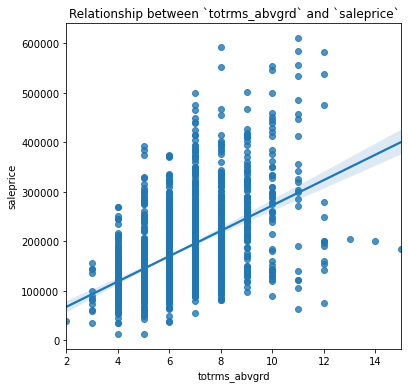

In [61]:
scatter_w_saleprice(ames_eda['totrms_abvgrd'])

The only observation I'm really concerned about occurs at the extreme upper end of the rooms above ground axis. Inspect those:

In [62]:
#get properties with rooms above ground > 14:
ames_eda[ames_eda['totrms_abvgrd']>14][ames_numerics] 

,lot_frontage,lot_area,mas_vnr_area,total_bsmt_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,...,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,misc_val,saleprice
1885,128.0,39290,1224.0,5095.0,0,5095,1.0,1.0,2,1,...,15,2,1154.0,546,484,0,0,0,17000,183850


I think given how many observations appear to fall above the regression plot, it's fair to say this observation has an adverse outlier effect on the relationship with `saleprice`. ~~Add property 1885 to the list of rows to drop~~This observation is already in our `outliers_to_drop` list!.

---

#### Outliers: `mas_vnr_area`

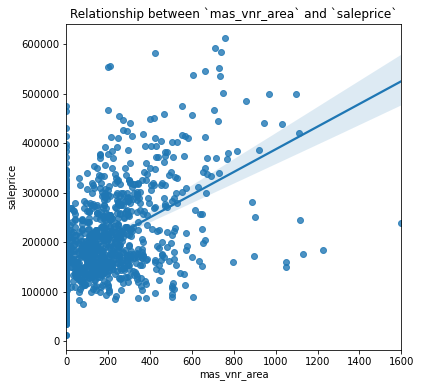

In [63]:
scatter_w_saleprice(ames_eda['mas_vnr_area'])

Biggest concern here is the observation way over by 1600 on the `mas_vnr_area` axis. Inspect (may be 1885 again):

In [64]:
list(ames_eda[ames_eda['mas_vnr_area']>1500].index)

[1409]

Oh no! This is property 1409. Let's add this to the list of observations to drop:

In [65]:
outliers_to_drop.append(1409)

---

#### Outliers: `fireplaces`

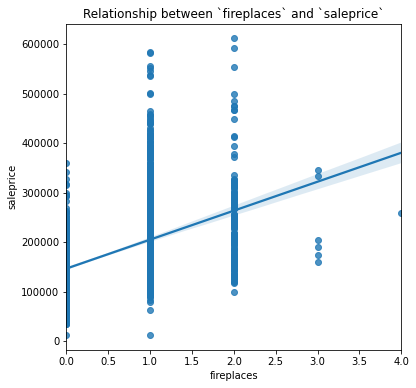

In [66]:
scatter_w_saleprice(ames_eda['fireplaces'])

Same as with the last couple variables we've reviewed, the plot point on the 4.0 end of `fireplaces` may need removal:

In [67]:
ames_eda[ames_eda['fireplaces']>3.5]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,...,3ssn_porch,screen_porch,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
761,2499,80,RL,100.0,14330,Pave,None,IR1,Low,AllPub,...,0,0,Gd,GdPrv,None,0,1,2006,WD,260000


I think unlike the last field, I'm okay with leaving this observation in. The properties with more than 2 fireplaces is sparsely populated as it is, so I don't think it will hurt the model too much to leave that observation in.

---

#### Outliers: `lot_frontage`

Our imputed NAs column!

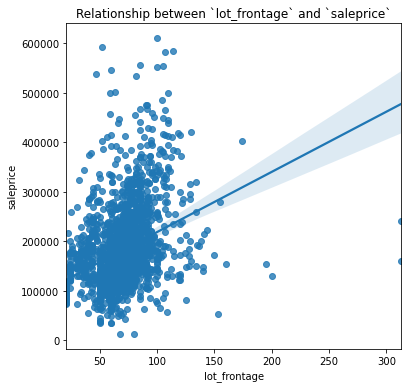

In [68]:
scatter_w_saleprice(ames_eda['lot_frontage'])

Two obvious culprits which may be outliers here, with `lot_frontage > 300`. Inspect:

In [69]:
ames_eda[ames_eda['lot_frontage']>300]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,...,3ssn_porch,screen_porch,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
960,1499,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,...,0,0,Gd,None,None,0,1,2008,New,160000
1335,1266,20,RL,313.0,27650,Pave,None,IR2,HLS,AllPub,...,0,0,None,None,None,0,11,2008,WD,242000


Property 960 is already in our drop list, but 1335 is not. Add 1335:

In [70]:
outliers_to_drop.append(1335)

---

#### Outliers: `open_porch_sf`

We're getting down to the final couple fields I'd like to inspect for outliers.

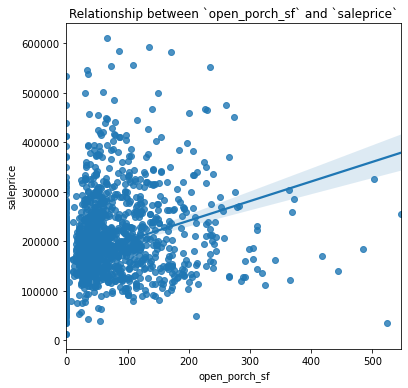

In [71]:
scatter_w_saleprice(ames_eda['open_porch_sf'])

This relationship with `saleprice` is so conical as we ascend on the `open_porch_sf` scale, I'm not sure how to deal with outliers. I think I am just going to add the one with a really low `saleprice` and over 500 `open_porch_sf`:

In [72]:
ames_eda[(ames_eda['open_porch_sf']>500) & (ames_eda['saleprice']<50000)]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,...,3ssn_porch,screen_porch,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1309,727,30,C (all),60.0,7879,Pave,None,Reg,Lvl,AllPub,...,0,0,None,GdWo,None,0,11,2009,WD,34900


In [73]:
#it's not yet in the list, so add it:
outliers_to_drop.append(1309)

---

#### Outliers: `wood_deck_sf`

This is the last feature for which I'll inspect for outliers... all of the other numeric features for which we looked at correlation strength against `saleprice` have equal to or less than .30 correlation (in absolute terms) to our target.

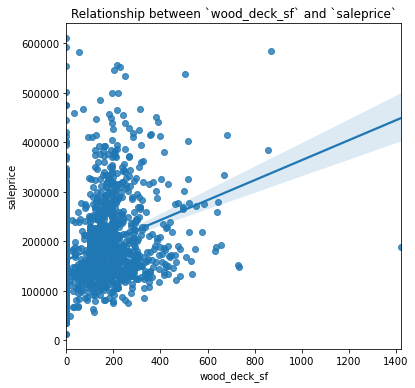

In [74]:
scatter_w_saleprice(ames_eda['wood_deck_sf'])

Just the one strange plot point out there with over 1400 square feet of wood deck:

In [75]:
ames_eda[ames_eda['wood_deck_sf']>1400]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,...,3ssn_porch,screen_porch,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
966,2294,80,RL,91.4,15957,Pave,None,IR1,Low,AllPub,...,0,0,None,MnPrv,None,0,9,2007,WD,188000


In [76]:
#add it to the list, since it's not already on there.
outliers_to_drop.append(966)

---

### Drop the Outliers

In [77]:
#starting with 2051 observations:
ames_eda.shape[0]

2051

In [78]:
ames_eda.drop(index=outliers_to_drop, inplace=True)

In [79]:
#ending with 2045:
ames_eda.shape[0]

2045

---

## Time to Save Our Work

That's about the extent of the inital cleaning I'd like to do on this dataset. If any issues come up in model tuning, I may return if the situation calls for it, but for now, I'll export our cleaned `ames_eda` dataframe as a .csv to our `/datasets/` directory.

In [80]:
ames_eda.to_csv('../datasets/cleaned/ames_train_clean.csv',index=False)

---

### Summary Statistics

In [81]:
ames_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
lot_frontage,2045.0,69.025428,20.654052,21.0,59.0,69.0,80.0,200.0
lot_area,2045.0,10015.491443,6601.740878,1300.0,7500.0,9405.0,11500.0,159000.0
mas_vnr_area,2045.0,97.145721,168.823874,0.0,0.0,0.0,158.0,1129.0
total_bsmt_sf,2045.0,1053.372127,427.018360,0.0,793.0,994.0,1318.0,3206.0
low_qual_fin_sf,2045.0,5.529095,51.142894,0.0,0.0,0.0,0.0,1064.0
gr_liv_area,2045.0,1495.498289,485.676618,334.0,1128.0,1444.0,1728.0,3820.0
bsmt_full_bath,2045.0,0.425428,0.520555,0.0,0.0,0.0,1.0,3.0
bsmt_half_bath,2045.0,0.063081,0.251086,0.0,0.0,0.0,0.0,2.0
full_bath,2045.0,1.576528,0.549539,0.0,1.0,2.0,2.0,4.0
half_bath,2045.0,0.370660,0.500997,0.0,0.0,0.0,1.0,2.0


---

#### Distributions

For the 11 continuous variables most correlated with `saleprice`, review the distributions in a pairplot:

In [82]:
#We defined 'corr' earlier to create our correlation heatmap. It still has '1st_flr_sf' in it, so remove that:
corr.drop(index='1st_flr_sf', inplace=True)



<Figure size 1008x1008 with 0 Axes>

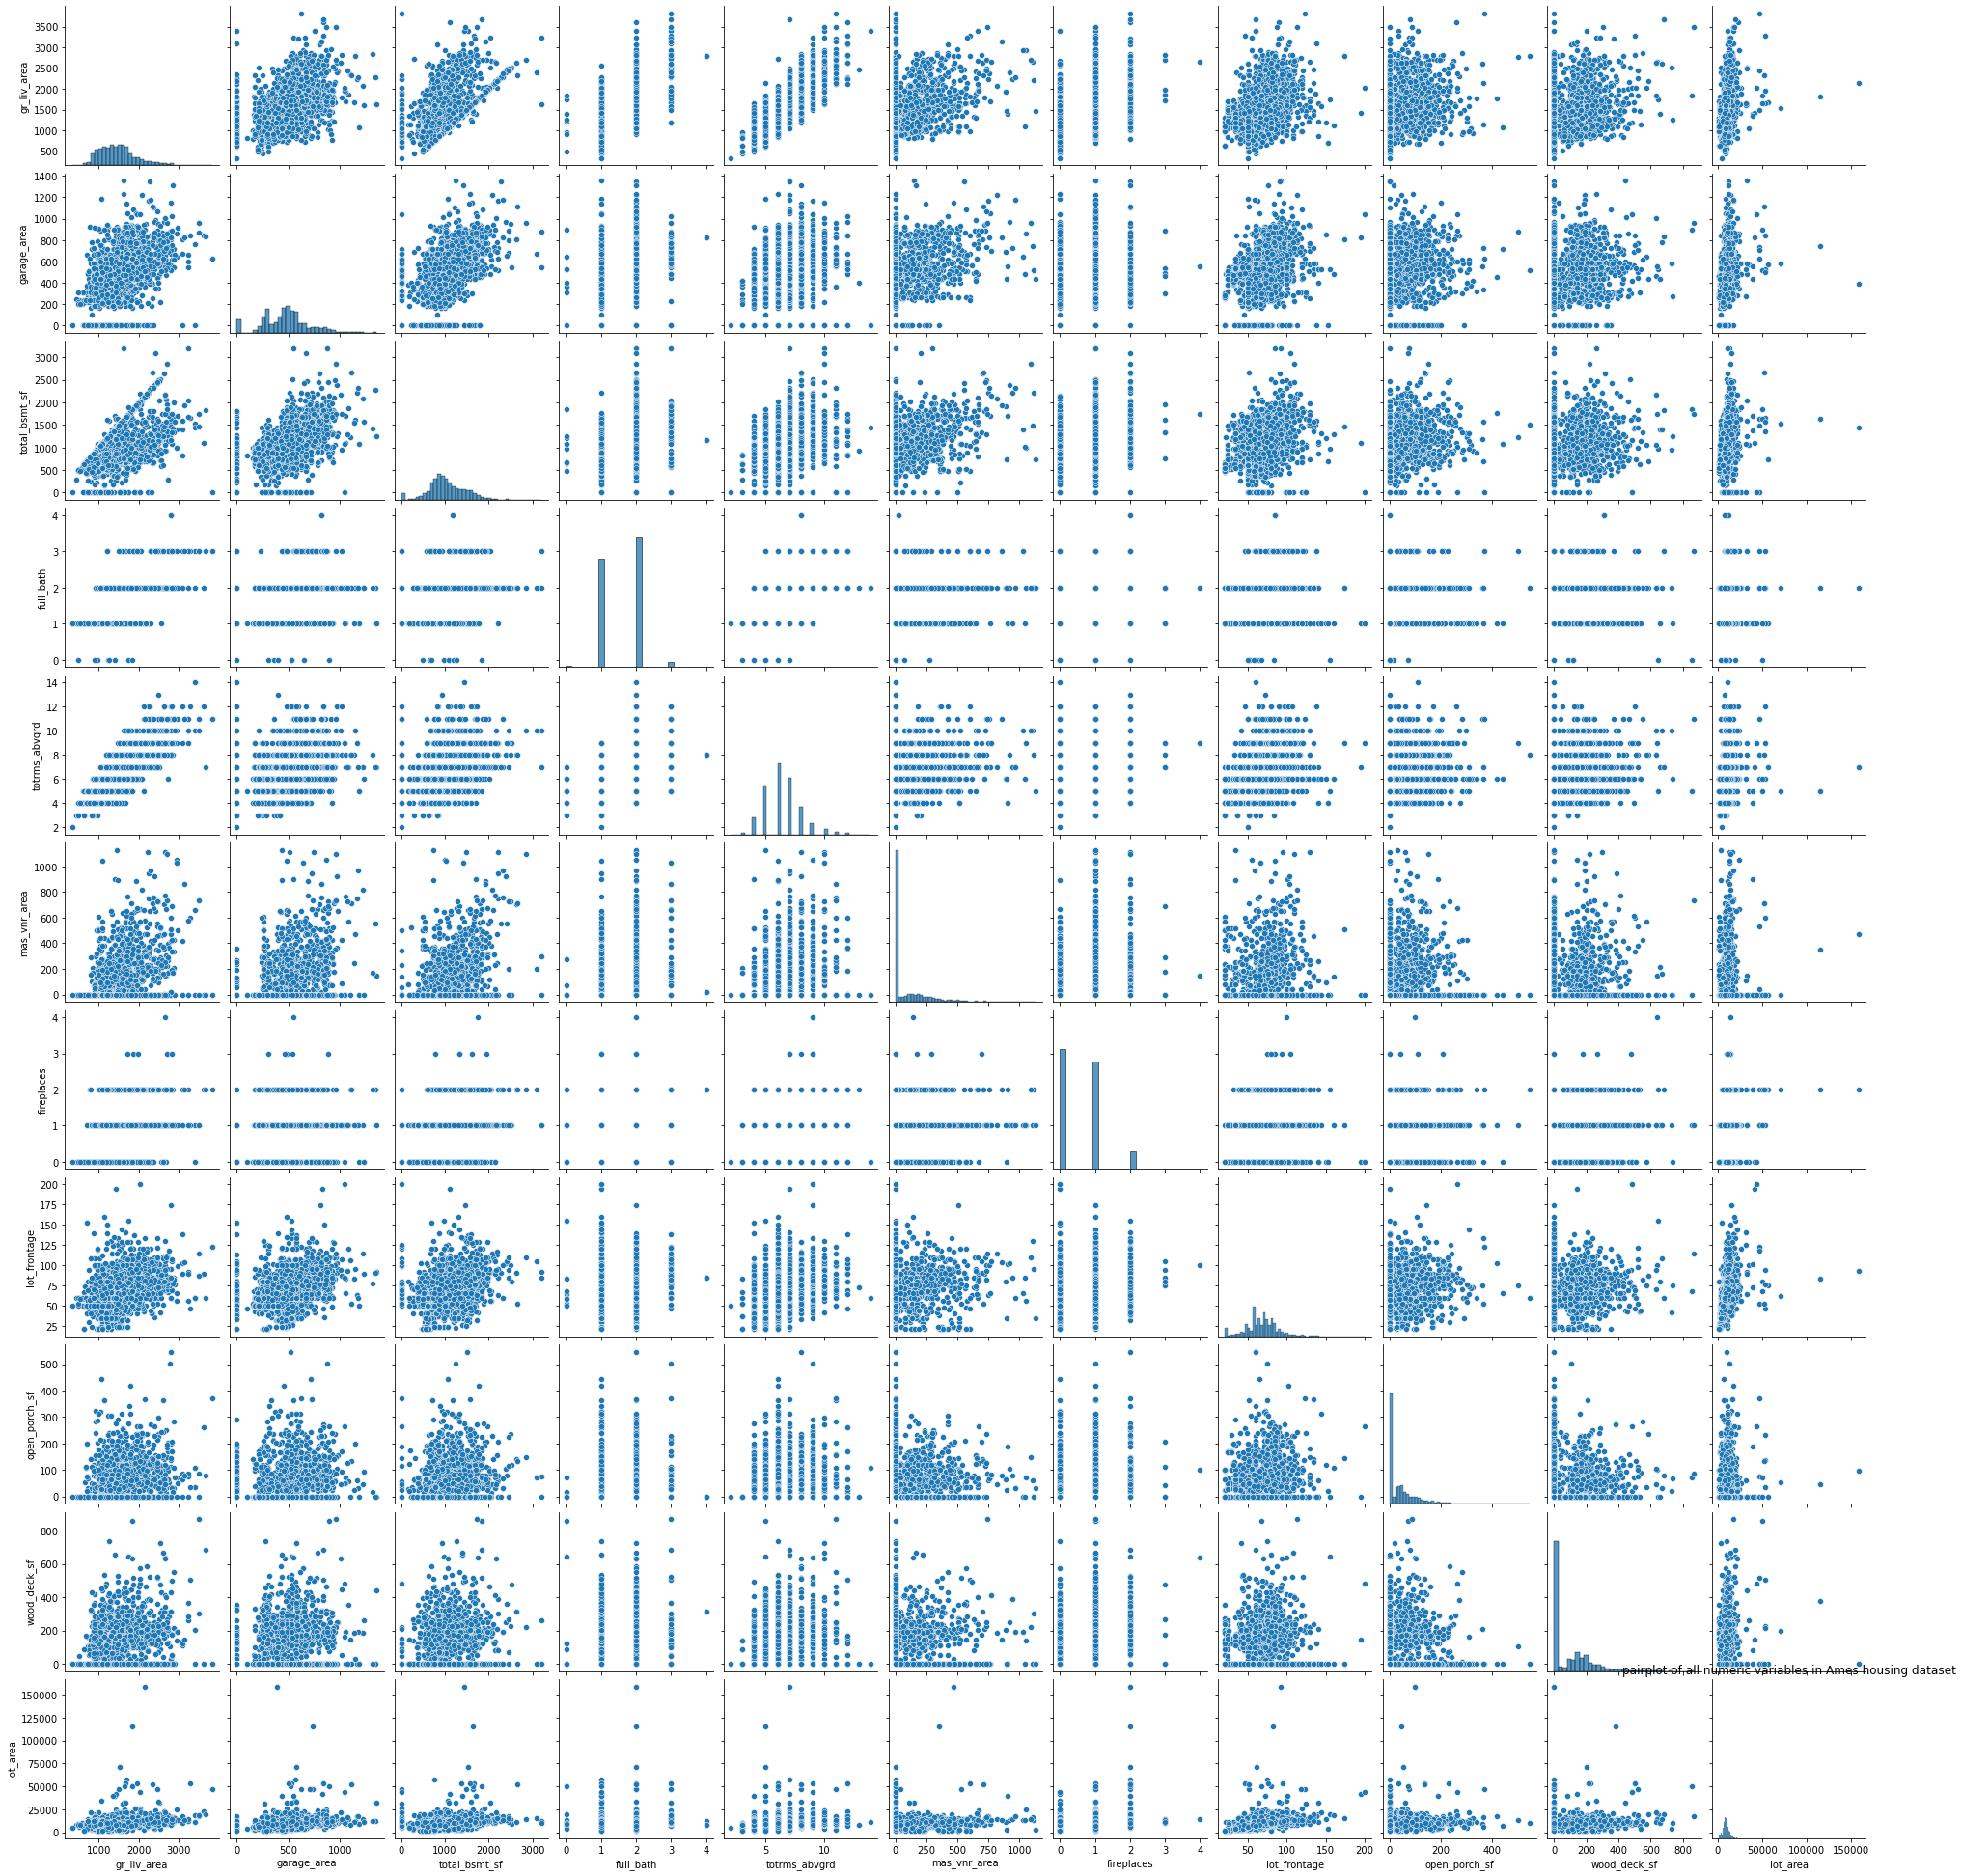

In [83]:
#Use it now to run a pairplot:
plt.figure(figsize=(14,14))

sns.pairplot(ames_eda[list(corr[:11].index)])
plt.title('pairplot of all numeric variables in Ames housing dataset');

Some observations: 

* Most of the histgrams illustrate **approximately normal distributions**. In some variables, such as `open_porch_sf`, `mas_vnr_area`, `wood_deck_sf`, and even to an extent `garage_area`, there is a pronounced frequency of properties with 0 in the category. In these cases, the value of zero denotes an absence of an open porch, masonry veneer, a wood deck, and a garage.
* In most of these variable pairs, there is no discernable relationship between between the x and y variable. A couple of cases where there may be collinearity:
     * Between `gr_liv_area`, `garage_area`, and `total_bsmt_sf`. The first variable represents (per the Dictionary) above-ground living area. This may or may not include area in the garage, measured by `garage_area`, and generally speaking, there is usually as much above-ground living area as there might be below-ground (measured by `total_bsmt_sf`). In model tuning, it might be good to check how the model does with and without the `garage_area` and `total_bsmt_sf` variables included in the model.

#### Honing in on the distribution of `saleprice`:

Looking more closely at `saleprice` in this dataset, we see that the distribution is not perfectly normal, and exhibits a skew toward homes on the higher end of the price spectrum. In ideal modeling situation, we'd have a perfectly normal distribution to work with, but this should be adequate for our purposes.

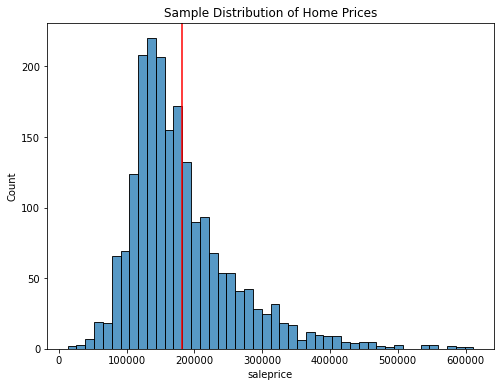

In [84]:
plt.figure(figsize=(8,6))
sns.histplot(x=ames_eda['saleprice'])
plt.title('Sample Distribution of Home Prices')
plt.axvline(ames_eda['saleprice'].mean(),color='red');